In [1]:
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import scipy
import json
import numpy as np

# 1 -> Frontal wall
# 2 -> Left wall
# 3 -> Right wall
# 4 -> Floor 
# 5 -> Ceiling

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 25
EPOCHS = 30
LR = 1e-3
IMAGE_SIZE = (128, 128) 

DATASET_PATH = "Dataset_floor"

In [2]:
files = os.listdir(DATASET_PATH)

paths = [os.path.join(DATASET_PATH, os.path.splitext(f)[0]) for f in files if f.endswith('.jpg')]

train_paths, val_paths = train_test_split(
    paths, test_size=0.2, random_state=5
)

In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = cv2.imread(f'{self.paths[idx]}.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask =  cv2.imread(f'{self.paths[idx]}.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = (mask > 0).astype(np.float32)
        # mask = torch.from_numpy(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.float()

In [11]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[1], width=IMAGE_SIZE[0]),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.6),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.ElasticTransform(
        alpha=10,
        sigma=50,
        p=0.3
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[1], width=IMAGE_SIZE[0]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [12]:
train_dataset = SegmentationDataset(train_paths, transform=train_transform)
val_dataset = SegmentationDataset(val_paths, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


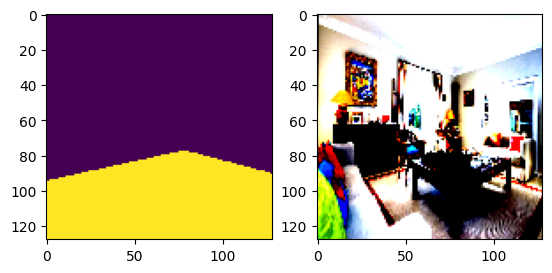

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[6][1])
ax[1].imshow(train_dataset[6][0].permute(1, 2, 0))

In [14]:
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [15]:
model.load_state_dict(torch.load('init.pth', map_location=DEVICE))
model = model.to(DEVICE)

In [17]:
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    pbar = tqdm(total=len(train_dataset), desc=f"Epoch {epoch+1}", unit="img")
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        pbar.update(BATCH_SIZE)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            val_loss += loss_fn(outputs, masks.unsqueeze(1)).item()

    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"model/checkpoints/model_{epoch + 1}.pth")

    with open("model/checkpoints/metrics_history.json", "w", encoding="utf-8") as f:
        json.dump(history, f, indent=4)

Epoch 1: 3525img [08:09,  7.20img/s]                                | 0/3512 [00:00<?, ?img/s]
Epoch 1: 3525img [04:23, 17.55img/s]                                                          

Epoch 1/30 | Train Loss: 0.1117 | Val Loss: 0.1348



Epoch 1: 3525img [04:35, 12.82img/s]                                | 0/3512 [00:00<?, ?img/s]

Epoch 2: 100%|██████████████████████████████████████████▊| 3500/3512 [04:46<00:00, 12.05img/s]
Epoch 2: 3525img [04:47, 14.09img/s]                                                          
Epoch 2: 3525img [04:58, 14.09img/s]

Epoch 2/30 | Train Loss: 0.0919 | Val Loss: 0.1331


Epoch 2: 3525img [05:15, 11.18img/s]                                | 0/3512 [00:00<?, ?img/s]
Epoch 3: 3525img [04:33, 17.96img/s]                                                          

Epoch 3/30 | Train Loss: 0.0796 | Val Loss: 0.1340



Epoch 3: 3525img [04:39, 12.61img/s]                                | 0/3512 [00:00<?, ?img/s]

Epoch 4:   8%|███▍                                        | 275/3512 [00:22<04:02, 13.32img/s]

KeyboardInterrupt: 


Epoch 4:   8%|███▍                                        | 275/3512 [00:34<04:02, 13.32img/s]

In [18]:
model.load_state_dict(torch.load('model/checkpoints/model_2.pth'))

<All keys matched successfully>

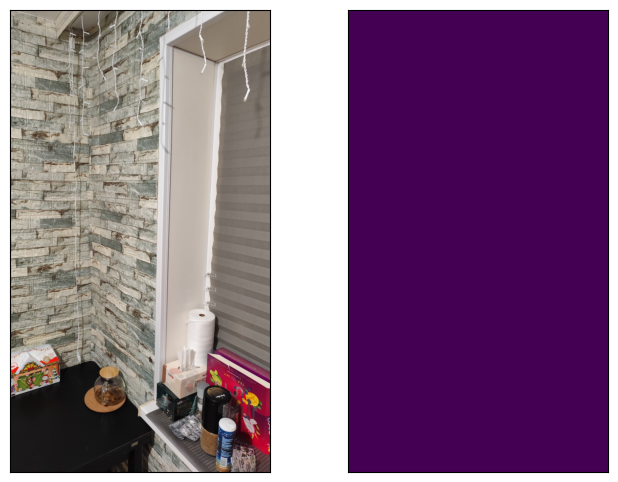

In [54]:
fig, ax = plt.subplots(1, 2, subplot_kw={'xticks': [], 'yticks': []}, figsize=(8, 6))
model.eval()

# p = paths[3]
p = 'img/data2/12'

img = cv2.imread(p + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)

im = val_transform(image=img)['image']
logits = model(im[None, :])
msk = torch.sigmoid(logits[0, 0]) > 0.5
msk = cv2.resize(np.where(msk, 255, 0).astype(np.uint8), img.shape[-2::-1])

ax[1].imshow(msk)
# print(torch.unique(msk))
# msk = np.argmax( axis=1)[0]

# ax[1].imshow(cv2.resize(np.where(np.array(msk) == 1, 255, 0).astype(np.uint8), img.shape[-2::-1]))
# ax[1].imshow(cv2.resize(np.array(msk), img.shape[-2::-1]))

# m = cv2.imread(p + '.png')
# ax[3].imshow(m)

In [71]:
smp.Unet?

Init signature:
smp.Unet(
    encoder_name: str = 'resnet34',
    encoder_depth: int = 5,
    encoder_weights: Optional[str] = 'imagenet',
    decoder_use_norm: Union[bool, str, Dict[str, Any]] = 'batchnorm',
    decoder_channels: Sequence[int] = (256, 128, 64, 32, 16),
    decoder_attention_type: Optional[str] = None,
    decoder_interpolation: str = 'nearest',
    in_channels: int = 3,
    classes: int = 1,
    activation: Union[str, Callable, NoneType] = None,
    aux_params: Optional[dict] = None,
    **kwargs: dict[str, typing.Any],
)
Docstring:     
U-Net is a fully convolutional neural network architecture designed for semantic image segmentation.

It consists of two main parts:

1. An encoder (downsampling path) that extracts increasingly abstract features
2. A decoder (upsampling path) that gradually recovers spatial details

The key is the use of skip connections between corresponding encoder and decoder layers.
These connections allow the decoder to access fine-grained detai